# Trabajo Practico
Alumna: Sabrina Benedetto

#### Objetivo
Entrenar modelos de machine learning que ayuden a predecir patrones de las categorías programáticas del gasto. 

#### Información
El dataset se arma a partit de los datos de "Presupuesto de gastos y su ejecución detallada - agrupación anual XXXX. Distribución anual acumulada de los créditos presupuestarios con todos los clasificadores. XXXX.", formato zip, publicados en <https://datos.gob.ar/>.  
Se toma en cuenta la información a partir del año 2002, cuando se abandona la convertibilidad cambiaria y comienza el modelo de flotación del peso con un tipo de cambio libre, que se mantiene hasta la actualidad.  

Por otro lado, se accederá a la información del presupuesto del año 2025 a través de la **API del presupuesto abierto** <https://datos.gob.ar/dataset/sspre_api/archivo/sspre_API> disponible también en el portal de datos abiertos del Gobierno Nacional. La API se utilizará para aplicar el modelo a datos actuales y predecir los resultados del año en curso.

#### Introducción al tema
Las diferencias entre los valores presupuestados (*crédito presupuestado*) y los efectivamente ejecutados (*crédito devengado*) reflejan el grado de eficiencia del proceso presupuestario y de la asignación de recursos públicos.

Se plantea que el comportamiento de las categorías programáticas del gasto presupuestario está directamente influenciado por variables macroeconómicas, principalmente la variación del tipo de cambio y del nivel general de precios (inflación).  

En consecuencia, es posible predecir, mediante técnicas de aprendizaje automático, si una categoría programática presentará un desvío entre la ejecución presupuestaria y el presupuesto inicial, así como la magnitud esperada de dicha desviación, en función del contexto macroeconómico observado.

La situación de ejecución presupuestaria se define a partir del ratio de **Eficiencia del Crédito Presupuestado (ECP)**, definido como:  
$$
\text{ECP} = \frac{\text{Crédito Devengado (CD)}}{\text{Crédito Presupuestado (CP)}}
$$

Donde, si:  
- ECP > 1 → Planificación ineficiente. Ampliaciones significativas del crédito no previstas (cambios en la política presupuestaria programada), gastos no controlados o shocks externos.
- ECP < 1 → Planificación ineficiente. Subutilización del crédito previsto, subestimación de restricciones presupuestarias o reducciones por reasignación (cambios en la política presupuestaria programada).
- ECP = 1 → Planificación eficiente. Correspondencia entre lo planificado y lo ejecutado. 

#### Hipótesis  
La planificación presupuestaria es afectada por las variables macroeconómicas, tales como el tipo de cambio y el nivel general de precios, generando desvíos entre el crédito presupuestado inicial y la ejecución final.  

**Hipótesis nula (H₀)**
No existe relación estadísticamente significativa entre la eficiencia del crédito presupuestado (medida por el ratio ECP) y las variables macroeconómicas consideradas (tipo de cambio e inflación).
En consecuencia, dichas variables no permiten predecir de manera confiable si una categoría programática presentará ineficiencias en la ejecución presupuestaria.  

**Hipótesis alternativa (H₁)**  
Existe una relación estadísticamente significativa entre la eficiencia del crédito presupuestado (medida por el ratio ECP) y las variables macroeconómicas analizadas (tipo de cambio e inflación).
Por lo tanto, es posible predecir el comportamiento de la eficiencia del crédito presupuestado a partir de estas variables. 

# A. Datos presupuestarios

In [91]:
# Librerías
# =================================================================================================
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Datos presupuestarios - Carga de datasets históricos (2002-2024)
# ==================================================================================================
dfs = []

for anio in range(2002, 2025):  # incluye 2024
    url = f"https://dgsiaf-repo.mecon.gob.ar/repository/pa/datasets/{anio}/credito-anual-{anio}.zip"
    print(f"🔄 Intentando descargar {anio}...")

    r = requests.get(url)
    if r.status_code != 200:
        print(f"❌ No se pudo descargar el archivo de {anio} (status {r.status_code})")
        continue

    carpeta = f"data/{anio}"
    os.makedirs(carpeta, exist_ok=True)

    # Descomprimir en carpeta
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(carpeta)
        print(f"✅ Archivo de {anio} descargado y extraído en '{carpeta}'")
    except Exception as e:
        print(f"❌ Error al descomprimir {anio}: {e}")
        continue

    # Buscar CSV dentro de la carpeta
    archivos = [f for f in os.listdir(carpeta) if f.endswith(".csv")]
    if not archivos:
        print(f"⚠️ No se encontró CSV en {anio}")
        continue

    archivo_csv = os.path.join(carpeta, archivos[0])

    # Leer CSV
    try:
        df = pd.read_csv(archivo_csv, sep=",", low_memory=False)  # uso el low_memory=False apra eliminar los warnings
        df["anio"] = anio                                         # columna extra para identificar año
        dfs.append(df)
        print(f"✅ CSV de {anio} leído correctamente ({len(df)} filas)")
    except Exception as e:
        print(f"❌ Error leyendo {archivo_csv}: {e}")

🔄 Intentando descargar 2002...
✅ Archivo de 2002 descargado y extraído en 'data/2002'
✅ CSV de 2002 leído correctamente (62853 filas)
🔄 Intentando descargar 2003...
✅ Archivo de 2003 descargado y extraído en 'data/2003'
✅ CSV de 2003 leído correctamente (60885 filas)
🔄 Intentando descargar 2004...
✅ Archivo de 2004 descargado y extraído en 'data/2004'
✅ CSV de 2004 leído correctamente (66129 filas)
🔄 Intentando descargar 2005...
✅ Archivo de 2005 descargado y extraído en 'data/2005'
✅ CSV de 2005 leído correctamente (80890 filas)
🔄 Intentando descargar 2006...
✅ Archivo de 2006 descargado y extraído en 'data/2006'
✅ CSV de 2006 leído correctamente (87924 filas)
🔄 Intentando descargar 2007...
✅ Archivo de 2007 descargado y extraído en 'data/2007'
✅ CSV de 2007 leído correctamente (98161 filas)
🔄 Intentando descargar 2008...
✅ Archivo de 2008 descargado y extraído en 'data/2008'
✅ CSV de 2008 leído correctamente (103842 filas)
🔄 Intentando descargar 2009...
✅ Archivo de 2009 descargado y

In [92]:
# Verificar que los datos se leyeron bien
print(f"DataFrames descargados: {len(dfs)}")
print(f"Ejemplo - primer DF: {dfs[0].shape}")

DataFrames descargados: 23
Ejemplo - primer DF: (62853, 53)


In [93]:
# Concatenar todos los DataFrames
df_presupuesto_anual = pd.concat(dfs, ignore_index=True)
print("✅ Datos concatenados exitosamente!")
print(f"📊 Total registros: {len(df_presupuesto_anual):,}")
print(f"📋 Total columnas: {len(df_presupuesto_anual.columns)}")

# Verificar años incluidos
if 'anio' in df_presupuesto_anual.columns:
    print(f"📅 Años incluidos: {sorted(df_presupuesto_anual['anio'].unique())}")

# Guardar
os.makedirs("data_anual_unificada", exist_ok=True)
archivo_unificado = "data_anual_unificada/presupuesto_anual_2002_2024.csv"
df_presupuesto_anual.to_csv(archivo_unificado, index=False, encoding="utf-8")
print(f"💾 Guardado en: {archivo_unificado}")

✅ Datos concatenados exitosamente!
📊 Total registros: 2,581,397
📋 Total columnas: 57
📅 Años incluidos: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
💾 Guardado en: data_anual_unificada/presupuesto_anual_2002_2024.csv


## 1. Limpieza y transformación de datos

### Paso 1️⃣ Homogeneizar columnas

Verificar que los CSV de distintos años tengan siempre los mismos nombres de columnas y así evitar columnas duplicadas o vacías que pueden generar errores o exceso de información.

In [94]:
# Verificar consistencia en NOMBRES de columnas entre años
print("🔍 Verificando nombres de columnas por año:\n")

# Recopilar nombres de columnas por año
columnas_por_año = {}
for i, df in enumerate(dfs):
    año = 2002 + i
    columnas_por_año[año] = list(df.columns)
    print(f"{año}: {len(df.columns)} columnas")

print("\n" + "="*50)
# Comparar cada año con el año base (2002)
año_base = 2002
columnas_base = set(columnas_por_año[año_base])

print(f"📋 Usando {año_base} como año base ({len(columnas_base)} columnas)")
print(f"🔍 Comparando todos los años contra {año_base}:\n")

# Calcular columnas comunes a TODOS los años
columnas_comunes = columnas_base.copy()  # Empezar con el año base
for año, columnas in columnas_por_año.items():
    columnas_comunes = columnas_comunes.intersection(set(columnas))

print(f"📋 Usando {año_base} como año base ({len(columnas_base)} columnas)")

# Mostrar columnas comunes
print(f"\n✅ Columnas comunes a TODOS los años: {len(columnas_comunes)}")
columnas_comunes_lista = sorted(list(columnas_comunes))
for i, col in enumerate(columnas_comunes_lista):
    print(f"  {i+1}. {col}")

print(f"\n🔍 Comparando todos los años contra {año_base}:\n")

# Mostrar columnas diferentes
años_inconsistentes = []
for año, columnas in columnas_por_año.items():
    if año == año_base:
        continue
    
    columnas_actuales = set(columnas)
    
    # Columnas que faltan en el año actual
    faltan = columnas_base - columnas_actuales
    # Columnas nuevas en el año actual
    nuevas = columnas_actuales - columnas_base
    
    if faltan or nuevas:
        años_inconsistentes.append(año)
        print(f"⚠️  {año}:")
        if faltan:
            print(f"   ❌ Faltan: {len(faltan)} columnas")
            for col in sorted(list(faltan)):  # Mostrar TODAS las columnas faltantes
                print(f"      - {col}")
        
        if nuevas:
            print(f"   ➕ Nuevas: {len(nuevas)} columnas")
            for col in sorted(list(nuevas)):  # Mostrar TODAS las columnas nuevas
                print(f"      - {col}")
    else:
        print(f"✅ {año}: Columnas idénticas")

print(f"\n📊 RESUMEN:")
print(f"✅ Años consistentes: {23 - len(años_inconsistentes)}/23")
print(f"⚠️  Cantidad de años inconsistentes: {len(años_inconsistentes)}/23")
if años_inconsistentes:
    print(f"   Años con columnas diferentes: {años_inconsistentes}")

🔍 Verificando nombres de columnas por año:

2002: 53 columnas
2003: 53 columnas
2004: 53 columnas
2005: 53 columnas
2006: 53 columnas
2007: 53 columnas
2008: 53 columnas
2009: 53 columnas
2010: 53 columnas
2011: 53 columnas
2012: 53 columnas
2013: 53 columnas
2014: 53 columnas
2015: 53 columnas
2016: 53 columnas
2017: 53 columnas
2018: 53 columnas
2019: 53 columnas
2020: 53 columnas
2021: 57 columnas
2022: 57 columnas
2023: 57 columnas
2024: 57 columnas

📋 Usando 2002 como año base (53 columnas)
🔍 Comparando todos los años contra 2002:

📋 Usando 2002 como año base (53 columnas)

✅ Columnas comunes a TODOS los años: 53
  1. actividad_desc
  2. actividad_id
  3. anio
  4. caracter_desc
  5. caracter_id
  6. clasificador_economico_8_digitos_desc
  7. clasificador_economico_8_digitos_id
  8. credito_comprometido
  9. credito_devengado
  10. credito_pagado
  11. credito_presupuestado
  12. credito_vigente
  13. ejercicio_presupuestario
  14. entidad_desc
  15. entidad_id
  16. finalidad_des

**Acción a tomar en este paso**: no es necesario homogeneizar, ya que las columnas adicionales son nuevas (no son duplicaciones originadas en distitnos nombres de columnas, sino nuevas columnas).

In [95]:
# Ver las primeras filas del DataFrame concatenado
print("Chequeo de columnas y filas:")
df_presupuesto_anual.head(3)

Chequeo de columnas y filas:


,impacto_presupuestario_anio,ejercicio_presupuestario,sector_id,sector_desc,subsector_id,subsector_desc,caracter_id,caracter_desc,jurisdiccion_id,jurisdiccion_desc,...,credito_vigente,credito_comprometido,credito_devengado,credito_pagado,ultima_actualizacion_fecha,anio,prestamo_externo_id,prestamo_externo_desc,codigo_bapin_id,codigo_bapin_desc
0,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,"38,048307","37,52890751","37,52890751","34,4396542",Última actualización del ejercicio 2002: 03 Ju...,2002,NaN,NaN,NaN,NaN
1,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,"13,648407","13,06813138","13,06813138","11,93889996",Última actualización del ejercicio 2002: 03 Ju...,2002,NaN,NaN,NaN,NaN
2,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,"4,370799","3,69697586","3,69697586","3,51404195",Última actualización del ejercicio 2002: 03 Ju...,2002,NaN,NaN,NaN,NaN


### Paso 2️⃣ Conversión de Tipos de Datos

#### Tipos de Datos Originales

Con `df.info()` podemos ver los tipos de datos que pandas asignó automáticamente basándose en el contenido de cada columna.

#### Identificación del tipo de dato que corresponde a cada variable
El portal de datos detalla los campos de los datasets e indica el tipo de dato, la descripción y la unidad de medida de cada columna (opción CONSULTAR).  
En base a esta información hacemos el *casting* de datos.  

De este detalle se decide convertir a: 

**Variables Numéricas de tipo `float`(montos de créditos presupuestarios):**
- `credito_presupuestado`
- `credito_vigente` 
- `credito_comprometido`
- `credito_devengado`
- `credito_pagado`

**Variables de texto `string`(todas las demás):**
- Descripciones: `sector_desc`, `jurisdiccion_desc`, `programa_desc`, etc.
- IDs: `sector_id`, `jurisdiccion_id`, `programa_id`, etc.

Se convierten los IDs a string y no a enteros porque algunos campos como `fuente_financiamiento_id` utilizan puntos (ej: 1.1, 2.3) pero no se corresponde con un formato decimal, sino al esquema del nomenclador presupuestario y representan subcategorías. Por lo tanto, todos los IDs se tratan como strings.

**Unidad de medida**: los créditos presupuestarios se expresan en millones de pesos corrientes.

In [96]:
# Veo la info general del df
print("Información ORIGINAL del DataFrame:")
df_presupuesto_anual.info()

Información ORIGINAL del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2581397 entries, 0 to 2581396
Data columns (total 57 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   impacto_presupuestario_anio            int64  
 1   ejercicio_presupuestario               int64  
 2   sector_id                              int64  
 3   sector_desc                            object 
 4   subsector_id                           int64  
 5   subsector_desc                         object 
 6   caracter_id                            int64  
 7   caracter_desc                          object 
 8   jurisdiccion_id                        int64  
 9   jurisdiccion_desc                      object 
 10  subjurisdiccion_id                     int64  
 11  subjurisdiccion_desc                   object 
 12  entidad_id                             int64  
 13  entidad_desc                           object 
 14  servicio_id   

In [97]:
# 1. Convierto TODO a string primero usando la función .astype(tipo) que convierte toda la columna al tipo indicado
# Creo un diccionario con todas las columnas que no son de crédito
columnas_string = {}
columnas_creditos = ['credito_presupuestado', 'credito_vigente', 'credito_comprometido', 
                     'credito_devengado', 'credito_pagado']
columnas_años = ['anio', 'impacto_presupuestario_anio', 'ejercicio_presupuestario']

# Identifico todas las columnas que van como string
for col in df_presupuesto_anual.columns:
    if col not in columnas_creditos and col not in columnas_años:
        columnas_string[col] = "string"

# Aplicar conversiones
df_presupuesto_anual = df_presupuesto_anual.astype(columnas_string)

# 2. Convierto columnas de créditos a float
# Uso `pd.to_numeric(errors='coerce')` porque convierte automáticamente valores inválidos a `NaN`
# en caso de que haya valores faltantes, caracteres especiales como separadores de miles,  o inconsistencias en el formato)

for col in columnas_creditos:
    if col in df_presupuesto_anual.columns:
        df_presupuesto_anual[col] = pd.to_numeric(df_presupuesto_anual[col], errors='coerce')

In [98]:
# 3. Chequeo los tipos de datos con .info()
# Ver todos los tipos de datos del DataFrame
print("Información del DataFrame luego de conversión de tipos de datos:")
print(df_presupuesto_anual.dtypes)

Información del DataFrame luego de conversión de tipos de datos:
impacto_presupuestario_anio                       int64
ejercicio_presupuestario                          int64
sector_id                                string[python]
sector_desc                              string[python]
subsector_id                             string[python]
subsector_desc                           string[python]
caracter_id                              string[python]
caracter_desc                            string[python]
jurisdiccion_id                          string[python]
jurisdiccion_desc                        string[python]
subjurisdiccion_id                       string[python]
subjurisdiccion_desc                     string[python]
entidad_id                               string[python]
entidad_desc                             string[python]
servicio_id                              string[python]
servicio_desc                            string[python]
programa_id                            

### Paso 3️⃣ Tratamiento a los valores ausentes (`NaN`)
Se analizarán los datos proporcionados a fin de detectar problemas en la calidad de los datos relacionados a los **valores ausentes**.

In [99]:
# Creo una tabla con la cantidad de nulos por columna y en porcentaje (para ver la magnitud del problema)
nulls_table = pd.DataFrame({
    'Nulos': df_presupuesto_anual.isnull().sum(),
    'Porcentaje': round((df_presupuesto_anual.isnull().sum() / len(df_presupuesto_anual)) * 100, 2)
})

# Ordeno de mayor a menor el porcentaje de nulos
nulls_table = nulls_table.sort_values(by="Porcentaje", ascending=False)

# Muestro tabla
display(nulls_table)

,Nulos,Porcentaje
codigo_bapin_desc,2115446,81.95
codigo_bapin_id,2062802,79.91
prestamo_externo_desc,2062802,79.91
prestamo_externo_id,2062802,79.91
credito_comprometido,2046195,79.27
credito_devengado,2043236,79.15
credito_pagado,1980877,76.74
credito_vigente,1478344,57.27
credito_presupuestado,1378454,53.40
jurisdiccion_desc,0,0.00


**Análisis de las variables con mayor cantidad de nulos**  

| Variable | Nulos | Porcentaje | Tratamiento |
|----------|-------|------------|-------------|
| **codigo_bapin_id** | 2062802 | 79.91% | La columna muestra el código que identifica un proyecto de inversión en el Banco de Proyectos de Inversión Pública (BAPIN). Solo tendrán valores aquellos registros que se correspondan con un proyecto de inversión. Asimismo, la columna aparece recién en 2021, por lo que todos los años anteriores serán valores `NaN`. **Tratamiento: Se dejan los nulos.** |
| **codigo_bapin_desc** | 2115446 | 81.95% | Nueva columna desde 2021, por lo que todos los años anteriores serán valores `NaN`. Refiere a la descripción del código que identifica al proyecto en el Banco de Proyectos de Inversión Pública (BAPIN). La mayor cantidad de nulos en relación con la cantidad de codigo_bapin_id indica que en algunos años cambia la descripción asignada a un mismo código. **Tratamiento: Se dejan los nulos.** |
| **prestamo_externo_desc** | 2062802 | 79.91% | Nueva columna desde 2021, por lo que todos los años anteriores serán valores `NaN`. Refiere a la descripción de un Préstamo Externo. La cantidad de nulos coinciden con la de códigos BAPIN, porque cada préstamo está asociado a un proyecto de inversión al que financia. **Tratamiento: Se dejan los nulos.** |
| **prestamo_externo_id** | 2062802 | 79.91% | Nueva columna desde 2021, por lo que todos los años anteriores serán valores `NaN`. Refiere al código identificador de un Préstamo Externo. La cantidad de nulos coinciden con la de códigos BAPIN, porque cada préstamo está asociado a un proyecto de inversión al que financia. **Tratamiento: Se dejan los nulos.** |
| **credito_comprometido** | 2046195 | 79.27% | Contiene los `NaN` correspondiente a los créditos presupuestarios de las columnas nuevas en los años donde esas columnas no existían, esto debido a que realicé la conversión del tipo de dato de la columna a float usando `pd.to_numeric(errors='coerce')`, que convierte automáticamente valores inválidos (valores faltantes, caracteres especiales como separadores de miles, o inconsistencias en el formato) a `NaN`. **Tratamiento: Se dejan los nulos.** |
| **credito_devengado** | 2043236 | 79.15% | [Misma explicación que credito_comprometido] |
| **credito_pagado** | 1980877 | 76.74% | [Misma explicación que credito_comprometido] |
| **credito_vigente** | 1478344 | 57.27% | [Misma explicación que credito_comprometido] |
| **credito_presupuestado** | 1378454 | 53.40% | [Misma explicación que credito_comprometido] |

In [100]:
# Análisis de las columnas con 35 nulos
columnas_35_nulos = ['proyecto_desc', 'subprograma_desc', 'programa_desc', 'obra_desc']
columnas_creditos = ['credito_vigente', 'credito_comprometido', 'credito_devengado', 'credito_pagado']

print("🔍 ANÁLISIS DE COLUMNAS CON 35 NULOS")
print("="*50)

# 1. Confirmo que todas tienen 35 nulos
print("\n1️⃣ Verificar cantidad de nulos:")
for col in columnas_35_nulos:
    nulos = df_presupuesto_anual[col].isnull().sum()
    print(f"   {col}: {nulos} nulos")

# 2. Verifico si los nulos están en las mismas filas
print("\n2️⃣ ¿Los nulos están en las mismas filas?")
filas_nulas = df_presupuesto_anual[df_presupuesto_anual['proyecto_desc'].isnull()]
coinciden_todas = True
for col in columnas_35_nulos[1:]:  # Comparar con la primera columna
    if not df_presupuesto_anual[col].isnull().equals(df_presupuesto_anual['proyecto_desc'].isnull()):
        coinciden_todas = False
        break

print(f"   {'✅ SÍ' if coinciden_todas else '❌ NO'} - Todas las columnas tienen nulos en las mismas filas")

# 3. Estado de columnas de crédito en esos registros
print("\n3️⃣ Estado de créditos en los 35 registros con nulos:")
print(f"   Total registros problemáticos: {len(filas_nulas)}")

for col_credito in columnas_creditos:
    if col_credito in df_presupuesto_anual.columns:
        nulos = filas_nulas[col_credito].isnull().sum()
        ceros = (filas_nulas[col_credito] == 0).sum()
        con_valores = len(filas_nulas) - nulos - ceros
        suma_total = filas_nulas[col_credito].sum()
        
        print(f"   {col_credito}: {nulos} nulos, {ceros} ceros, {con_valores} con valores (Total: ${suma_total:,.0f})")

print("\n📋 RESUMEN:")
print(f"   • Registros afectados: {len(filas_nulas)}")
print(f"   • Años afectados: {sorted(filas_nulas['anio'].unique())}")
print(f"   • ¿Tienen montos? {'SÍ' if filas_nulas[columnas_creditos].sum().sum() > 0 else 'NO'}")

🔍 ANÁLISIS DE COLUMNAS CON 35 NULOS

1️⃣ Verificar cantidad de nulos:
   proyecto_desc: 35 nulos
   subprograma_desc: 35 nulos
   programa_desc: 35 nulos
   obra_desc: 35 nulos

2️⃣ ¿Los nulos están en las mismas filas?
   ✅ SÍ - Todas las columnas tienen nulos en las mismas filas

3️⃣ Estado de créditos en los 35 registros con nulos:
   Total registros problemáticos: 35
   credito_vigente: 30 nulos, 5 ceros, 0 con valores (Total: $0)
   credito_comprometido: 25 nulos, 10 ceros, 0 con valores (Total: $0)
   credito_devengado: 25 nulos, 10 ceros, 0 con valores (Total: $0)
   credito_pagado: 15 nulos, 20 ceros, 0 con valores (Total: $0)

📋 RESUMEN:
   • Registros afectados: 35
   • Años afectados: [2004]
   • ¿Tienen montos? NO


**Análisis variables con 35 nulos**  
Variables afectadas: `proyecto_desc`, `subprograma_desc`, `programa_desc`, `obra_desc`.  
Siendo que el % de filas con valores nulos es muy bajo en el total, corresponden solo al año 2004 y no tienen valores monetarios (créditos asignados), se eliminan dichas filas. 

##### **Resumen tratamiento de los valores nulos**
- **Variables BAPIN y préstamos externos**: Son columnas nuevas desde 2021, por lo que es esperado que años anteriores tengan `NaN`. Se mantienen. 
- **Variables de crédito**: Los `NaN` son resultado de la conversión de tipos de datos y representan valores faltantes legítimos en el sistema presupuestario. Se mantienen.
- **Variables con 35 registros nulos**: presentan baja materialidad en la base de datos y que no tienen valores monetarios asignados en ninguna columna de crédito. Se eliminan.

In [101]:
# Eliminación de los 35 registros problemáticos del año 2004
print("🗑️ ELIMINACIÓN DE REGISTROS SIN VALOR")
print("="*50)

print(f"\n📊 Estado ANTES de eliminar:")
print(f"   Total filas: {len(df_presupuesto_anual):,}")
print(f"   Nulos en proyecto_desc: {df_presupuesto_anual['proyecto_desc'].isnull().sum()}")

# Eliminar filas donde proyecto_desc es nulo
df_presupuesto_anual_limpio = df_presupuesto_anual[df_presupuesto_anual['proyecto_desc'].notnull()].copy()

print(f"\n📊 Estado DESPUÉS de eliminar:")
print(f"   Total filas: {len(df_presupuesto_anual_limpio):,}")
print(f"   Registros eliminados: {len(df_presupuesto_anual) - len(df_presupuesto_anual_limpio)}")

# Verificar que se eliminaron correctamente
print(f"\n✅ Verificación de limpieza:")
columnas_verificar = ['proyecto_desc', 'subprograma_desc', 'programa_desc', 'obra_desc']
for col in columnas_verificar:
    nulos_restantes = df_presupuesto_anual_limpio[col].isnull().sum()
    print(f"   {col}: {nulos_restantes} nulos")

# Verificar que 2004 sigue existiendo en el dataset
print(f"\n📅 Años en el dataset limpio:")
años = sorted(df_presupuesto_anual_limpio['anio'].unique())
print(f"   {años}")
print(f"   ✅ Año 2004 {'presente' if 2004 in años else 'eliminado'} (se eliminaron solo 35 registros de 2004, no todo el año)")

print(f"\n🎉 Dataset limpio y listo para análisis!")

🗑️ ELIMINACIÓN DE REGISTROS SIN VALOR

📊 Estado ANTES de eliminar:
   Total filas: 2,581,397
   Nulos en proyecto_desc: 35

📊 Estado DESPUÉS de eliminar:
   Total filas: 2,581,362
   Registros eliminados: 35

✅ Verificación de limpieza:
   proyecto_desc: 0 nulos
   subprograma_desc: 0 nulos
   programa_desc: 0 nulos
   obra_desc: 0 nulos

📅 Años en el dataset limpio:
   [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
   ✅ Año 2004 presente (se eliminaron solo 35 registros de 2004, no todo el año)

🎉 Dataset limpio y listo para análisis!


### Paso 4️⃣ Reducción del dataset  

#### Valores iguales a cero
Para el análisis, se excluyen las categorías programáticas que no registran asignación presupuestaria en ninguna de sus etapas (crédito presupuestado, vigente, devengado y pagado), ya que no aportan información sobre el comportamiento de la ejecución presupuestaria y generarían ratios indefinidos.  

Esto quiere decir que antes de analizar los outliers, se filtran del dataset las filas donde TODAS las columnas monetarias tienen **valor = 0**. 

Estas filas pueden desestimarse ya que: 
- No aportan información sobre ejecución presupuestaria
- Ratio resulta indefinido: CD/CP = 0/0 (no se puede calcular)
- No son outliers, sino categorías vacías
- Distorsionan los cálculos estadísticos, ya que inflan artificialmente el conteo de "ceros"

In [102]:
# IDENTIFICAR FILAS CON TODAS LAS COLUMNAS DE CRÉDITO EN CERO
columnas_creditos = ['credito_presupuestado', 'credito_vigente', 'credito_comprometido', 
                     'credito_devengado', 'credito_pagado']

print("🔍 ANÁLISIS DE REGISTROS SIN FONDOS ASIGNADOS")
print("="*60)

# Verificar filas donde TODAS las columnas de crédito son 0 o NaN
condicion_sin_fondos = True
for col in columnas_creditos:
    if col in df_presupuesto_anual_limpio.columns:
        condicion_sin_fondos = condicion_sin_fondos & (
            (df_presupuesto_anual_limpio[col] == 0) | 
            (df_presupuesto_anual_limpio[col].isna())
        )

filas_sin_fondos = df_presupuesto_anual_limpio[condicion_sin_fondos]

print(f"\n📊 Estadísticas:")
print(f"   Total filas en dataset: {len(df_presupuesto_anual_limpio):,}")
print(f"   Filas SIN fondos (todas columnas = 0 o NaN): {len(filas_sin_fondos):,}")
print(f"   Porcentaje: {(len(filas_sin_fondos)/len(df_presupuesto_anual_limpio)*100):.2f}%")

# Ver distribución por año
if len(filas_sin_fondos) > 0:
    print(f"\n📅 Distribución por año:")
    dist_años = filas_sin_fondos['anio'].value_counts().sort_index()
    for año, cantidad in dist_años.items():
        print(f"   {año}: {cantidad:,} registros sin fondos")

# Crear dataset filtrado para análisis de outliers
df_con_fondos = df_presupuesto_anual_limpio[~condicion_sin_fondos].copy()

print(f"\n✅ Dataset filtrado para análisis de outliers:")
print(f"   Filas con fondos asignados: {len(df_con_fondos):,}")
print(f"   Filas eliminadas: {len(df_presupuesto_anual_limpio) - len(df_con_fondos):,}")

# Verificar que efectivamente tienen valores
print(f"\n🔍 Verificación - Estadísticas de credito_presupuestado en dataset filtrado:")
print(f"   Mínimo: ${df_con_fondos['credito_presupuestado'].min():,.2f}")
print(f"   Máximo: ${df_con_fondos['credito_presupuestado'].max():,.2f}")
print(f"   Valores = 0: {(df_con_fondos['credito_presupuestado'] == 0).sum():,}")

🔍 ANÁLISIS DE REGISTROS SIN FONDOS ASIGNADOS

📊 Estadísticas:
   Total filas en dataset: 2,581,362
   Filas SIN fondos (todas columnas = 0 o NaN): 2,535,582
   Porcentaje: 98.23%

📅 Distribución por año:
   2002: 62,715 registros sin fondos
   2003: 60,803 registros sin fondos
   2004: 65,894 registros sin fondos
   2005: 80,579 registros sin fondos
   2006: 87,555 registros sin fondos
   2007: 97,802 registros sin fondos
   2008: 103,309 registros sin fondos
   2009: 111,947 registros sin fondos
   2010: 113,709 registros sin fondos
   2011: 124,313 registros sin fondos
   2012: 121,874 registros sin fondos
   2013: 129,998 registros sin fondos
   2014: 123,647 registros sin fondos
   2015: 131,188 registros sin fondos
   2016: 132,391 registros sin fondos
   2017: 129,819 registros sin fondos
   2018: 129,748 registros sin fondos
   2019: 119,705 registros sin fondos
   2020: 112,133 registros sin fondos
   2021: 125,076 registros sin fondos
   2022: 132,591 registros sin fondos
   2

⚠️ Dada la reducción de registros luego del filtro, se lleva a cabo un análisis exploratorio del dataset reducido para ver cuántos registros quedan por año, qué categorías programáticas quedaron y así evaluar si es viable para ML.

In [103]:
# EXPLORACIÓN DEL DATASET REDUCIDO
print("🔍 EXPLORACIÓN DEL DATASET CON FONDOS")
print("="*60)

# 1. Comparación general
print(f"\n📊 REDUCCIÓN DEL DATASET:")
print(f"   Dataset original limpio: {len(df_presupuesto_anual_limpio):,} registros")
print(f"   Dataset con fondos: {len(df_con_fondos):,} registros")
print(f"   Reducción: {((1 - len(df_con_fondos)/len(df_presupuesto_anual_limpio))*100):.2f}%")
print(f"   Datos útiles: {(len(df_con_fondos)/len(df_presupuesto_anual_limpio)*100):.2f}%")

# 2. Distribución por año
print(f"\n📅 REGISTROS POR AÑO:")
registros_año = df_con_fondos['anio'].value_counts().sort_index()
for año, cantidad in registros_año.items():
    pct = (cantidad / len(df_con_fondos)) * 100
    print(f"   {año}: {cantidad:>6,} registros ({pct:>5.2f}%)")

# Verificar si hay años con muy pocos datos
años_pocos_datos = registros_año[registros_año < 100]
if len(años_pocos_datos) > 0:
    print(f"\n   ⚠️  Años con < 100 registros: {list(años_pocos_datos.index)}")

# 3. Categorías programáticas disponibles
print(f"\n📋 CATEGORÍAS PROGRAMÁTICAS DISPONIBLES:")

categorias_clave = {
    'jurisdiccion_desc': 'Jurisdicciones',
    'sector_desc': 'Sectores',
    'finalidad_desc': 'Finalidades',
    'funcion_desc': 'Funciones',
    'programa_desc': 'Programas'
}

for col, nombre in categorias_clave.items():
    if col in df_con_fondos.columns:
        unicos = df_con_fondos[col].nunique()
        print(f"   {nombre}: {unicos:,} categorías únicas")

# 4. Jurisdicciones principales
print(f"\n🏛️ TOP 10 JURISDICCIONES (por cantidad de registros):")
top_jurisdicciones = df_con_fondos['jurisdiccion_desc'].value_counts().head(10)
for jurisdiccion, cantidad in top_jurisdicciones.items():
    pct = (cantidad / len(df_con_fondos)) * 100
    print(f"   {jurisdiccion[:50]}: {cantidad:>5,} ({pct:>5.2f}%)")

# 5. Distribución de montos por año (para ver nominalidad)
print(f"\n💰 PROMEDIO DE CRÉDITO DEVENGADO POR AÑO:")
for año in sorted(df_con_fondos['anio'].unique()):
    df_año = df_con_fondos[df_con_fondos['anio'] == año]
    cd_promedio = df_año['credito_devengado'].mean()
    cd_mediana = df_año['credito_devengado'].median()
    print(f"   {año}: Promedio ${cd_promedio:>12,.2f} | Mediana ${cd_mediana:>12,.2f}")

# 6. Evaluación para ML
print(f"\n\n🤖 EVALUACIÓN PARA MACHINE LEARNING:")
print("="*60)

min_registros_ml = 1000  # Mínimo recomendado por año para ML robusto

años_suficientes = registros_año[registros_año >= min_registros_ml]
años_insuficientes = registros_año[registros_año < min_registros_ml]

print(f"\n📊 Viabilidad por año (mínimo recomendado: {min_registros_ml:,} registros):")
print(f"   ✅ Años con datos suficientes: {len(años_suficientes)}")
if len(años_suficientes) > 0:
    print(f"      {list(años_suficientes.index)}")

print(f"   ⚠️  Años con datos insuficientes: {len(años_insuficientes)}")
if len(años_insuficientes) > 0:
    print(f"      {list(años_insuficientes.index)}")

print(f"\n✅ CONCLUSIÓN PRELIMINAR (parámetros sugeridos por IA): ")
if len(años_suficientes) >= 10:
    print(f"   ✅ Dataset VIABLE para ML (10 años o + con datos")
    print(f"   ✅ Suficientes años con datos ({len(años_suficientes)} años)")
    print(f"   ✅ Total registros: {len(df_con_fondos):,}")
elif len(años_suficientes) >= 5:
    print(f"   ⚠️  Dataset MARGINALMENTE viable (entre 5 y 10 años con datos")
    print(f"   ⚠️  Solo {len(años_suficientes)} años con datos suficientes")
    print(f"   💡 Considerar: agrupar años o usar menos categorías")
else:
    print(f"   ❌ Dataset INSUFICIENTE para ML robusto (menos de 5 años con datos")
    print(f"   ❌ Solo {len(años_suficientes)} años utilizables")
    print(f"   💡 Recomendación: revisar criterios de filtrado")

🔍 EXPLORACIÓN DEL DATASET CON FONDOS

📊 REDUCCIÓN DEL DATASET:
   Dataset original limpio: 2,581,362 registros
   Dataset con fondos: 45,780 registros
   Reducción: 98.23%
   Datos útiles: 1.77%

📅 REGISTROS POR AÑO:
   2002:    138 registros ( 0.30%)
   2003:     82 registros ( 0.18%)
   2004:    200 registros ( 0.44%)
   2005:    311 registros ( 0.68%)
   2006:    369 registros ( 0.81%)
   2007:    359 registros ( 0.78%)
   2008:    533 registros ( 1.16%)
   2009:    737 registros ( 1.61%)
   2010:    915 registros ( 2.00%)
   2011:    998 registros ( 2.18%)
   2012:  1,382 registros ( 3.02%)
   2013:  1,657 registros ( 3.62%)
   2014:  1,875 registros ( 4.10%)
   2015:  2,999 registros ( 6.55%)
   2016:  2,625 registros ( 5.73%)
   2017:  1,710 registros ( 3.74%)
   2018:  2,479 registros ( 5.42%)
   2019:  2,192 registros ( 4.79%)
   2020:  2,077 registros ( 4.54%)
   2021:  4,929 registros (10.77%)
   2022:  4,877 registros (10.65%)
   2023:  6,562 registros (14.33%)
   2024:  5,7

### Paso 5️⃣ Descubrir los valores anómalos o *outliers* 
Para descubrir los valores anómalos se utilizan los gráficos tipo boxplot, donde los puntos que aparecen fuera de las cajas se considerán valores anómalos.  
📌 **Aclaración**:  
- se analizan los outliers de las columnas que presentan valores monetarios (columnas de crédito)
- dada la nominalidad y las diferencias de escala, se analizan los outliers para cada año analizado

In [104]:
# ANÁLISIS DE OUTLIERS POR AÑO 
import numpy as np

columnas_creditos = ['credito_presupuestado', 'credito_vigente', 'credito_comprometido', 
                     'credito_devengado', 'credito_pagado']

print("🔍 ANÁLISIS DE OUTLIERS POR AÑO")
print("="*100)

# Tabla resumen
resultados_outliers = []
outliers_por_año_jurisdiccion = {}  # Para guardar outliers por año

# Cálculo de outliers por año y columna
for año in sorted(df_con_fondos['anio'].unique()):
    df_año = df_con_fondos[df_con_fondos['anio'] == año]
    outliers_año = []  # Lista para acumular índices de outliers de este año
    
    for col in columnas_creditos:
        if col in df_año.columns:
            # Filtro solo valores > 0 para el análisis
            datos = df_año[df_año[col] > 0][col]
            
            if len(datos) > 10:  # Necesitamos suficientes datos
                # Calcular IQR
                Q1 = datos.quantile(0.25)
                Q3 = datos.quantile(0.75)
                IQR = Q3 - Q1
                limite_inferior = Q1 - 1.5 * IQR
                limite_superior = Q3 + 1.5 * IQR
                
                # Conteo outliers
                outliers = datos[(datos < limite_inferior) | (datos > limite_superior)]
                pct_outliers = (len(outliers) / len(datos)) * 100
                
                # Guardar índices de outliers
                outliers_año.extend(outliers.index.tolist())
                
                resultados_outliers.append({
                    'año': año,
                    'columna': col,
                    'total_registros': len(datos),
                    'outliers': len(outliers),
                    'pct_outliers': pct_outliers,
                    'Q1': Q1,
                    'Q3': Q3,
                    'limite_sup': limite_superior,
                    'mediana': datos.median(),
                    'max': datos.max()
                })
    
    # Identificar top 3 jurisdicciones con más outliers en este año
    if outliers_año:
        jurisdicciones_outliers = df_con_fondos.loc[outliers_año, 'jurisdiccion_desc']
        top_jurisdicciones = jurisdicciones_outliers.value_counts().head(3)
        outliers_por_año_jurisdiccion[año] = top_jurisdicciones

# Creación DataFrame con resultados
df_outliers = pd.DataFrame(resultados_outliers)

# Creación tabla (pivoteada: años en filas, columnas de crédito en columnas)
tabla_outliers = df_outliers.pivot_table(
    index='año',
    columns='columna', 
    values='pct_outliers',
    aggfunc='mean'
).round(2)

# Se renombran las columnas (más cortas)
tabla_outliers.columns = [col.replace('credito_', '') for col in tabla_outliers.columns]

# Se agrega columna con promedio por año
tabla_outliers['PROMEDIO_AÑO'] = tabla_outliers.mean(axis=1).round(2)

# Se agrega fila con promedio por columna
tabla_outliers.loc['PROMEDIO TOTAL'] = tabla_outliers.mean().round(2)

print("\n📊 PORCENTAJE DE OUTLIERS POR AÑO Y COLUMNA:")
print(tabla_outliers.to_string())
print("-"*100)

promedio_total = df_outliers['pct_outliers'].mean()
print(f"{'PROMEDIO GENERAL':<25} {promedio_total:>10.2f}%")
print("-"*100)

# Años con más outliers (en total)
print("\n⚠️  TOP 10 AÑOS CON MÁS OUTLIERS (TOTAL COLUMNAS):")
print("-"*100)
años_problema = tabla_outliers.nlargest(10, 'PROMEDIO_AÑO')
for año in años_problema.index:
    if año != 'PROMEDIO TOTAL':
        pct = años_problema.loc[año, 'PROMEDIO_AÑO']
        print(f"  {año}: {pct:.2f}%")

# JURISDICCIONES QUE MÁS VECES APARECEN COMO OUTLIERS (TODOS LOS AÑOS)
print("\n\n🔍 JURISDICCIONES QUE MÁS VECES APARECEN COMO OUTLIERS (GLOBAL):")
print("="*100)

jurisdicciones_frecuentes = []  # Para acumular todas las jurisdicciones outliers

if jurisdicciones_frecuentes:
    from collections import Counter
    top_juris_outliers = Counter(jurisdicciones_frecuentes).most_common(10)
    
    print("\nTop 10 jurisdicciones con más registros outliers:")
    for juris, veces in top_juris_outliers:
        juris_corto = juris[:60] + "..." if len(juris) > 60 else juris
        print(f"  • {juris_corto:<63}: {veces:>6} veces")
    
    print("\n💡 Interpretación:")
    print("   Si las mismas jurisdicciones grandes siempre son outliers →")
    print("   Son características estructurales del presupuesto, NO errores")

# TOP 3 JURISDICCIONES CON MÁS OUTLIERS POR AÑO
print("\n\n🏛️  TOP 3 JURISDICCIONES CON MÁS OUTLIERS POR AÑO (TOTAL COLUMNAS):")
print("="*100)

for año in sorted(outliers_por_año_jurisdiccion.keys()):
    print(f"\n📅 {año}:")
    top_juris = outliers_por_año_jurisdiccion[año]
    for i, (jurisdiccion, cantidad) in enumerate(top_juris.items(), 1):
        # Acortar nombre de jurisdicción si es muy largo
        juris_corto = jurisdiccion[:65] + "..." if len(jurisdiccion) > 65 else jurisdiccion
        print(f"  {i}. {juris_corto:<68} → {cantidad:>4} outliers")


🔍 ANÁLISIS DE OUTLIERS POR AÑO

📊 PORCENTAJE DE OUTLIERS POR AÑO Y COLUMNA:
                comprometido  devengado  pagado  presupuestado  vigente  PROMEDIO_AÑO
año                                                                                  
2002                   14.29      15.79   13.33          21.51    10.96         15.18
2003                   19.23      19.23   18.75          13.95    11.32         16.50
2004                   15.38      15.79   15.38          17.78    12.39         15.34
2005                    8.89       9.76   16.13          13.57    13.70         12.41
2006                   15.15      15.38   20.00          13.42    14.04         15.60
2007                   10.53       5.66   23.26          14.57    17.06         14.22
2008                   13.83      13.98   16.44          14.36    16.85         15.09
2009                   13.82      14.41   17.89          13.39    12.54         14.41
2010                   15.95      15.72   21.01          13.16  


📊 GENERANDO HEATMAP DE OUTLIERS POR JURISDICCIÓN Y AÑO...


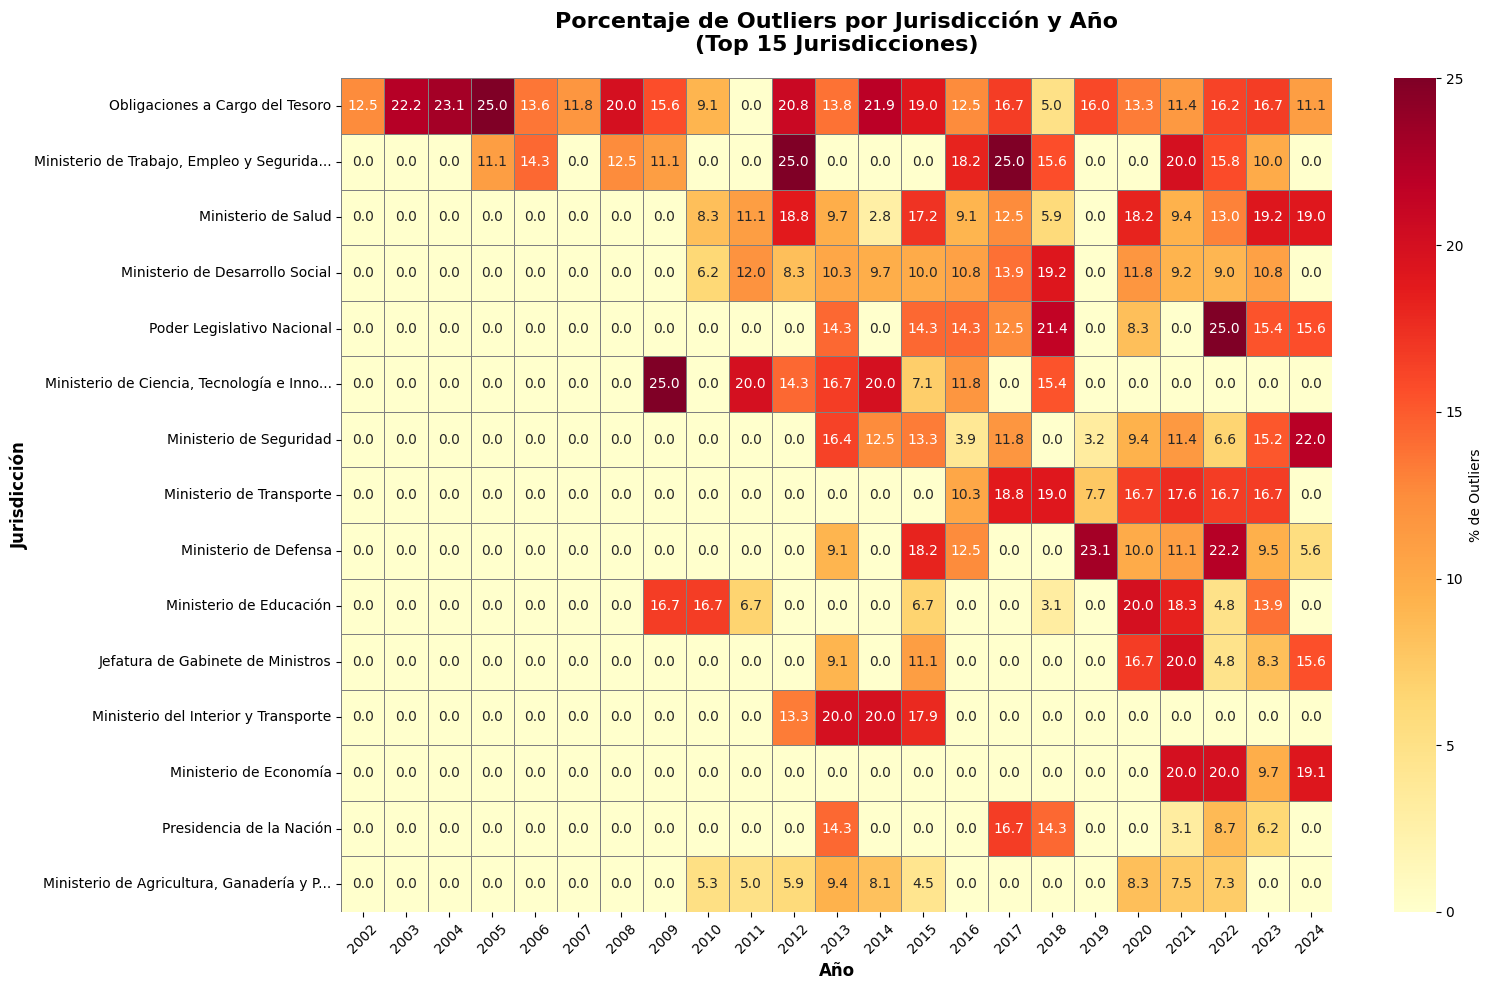

In [105]:
# Se crea un heat map (mapa de calor) para visualizar la presencia de outliers y facilitar el análisis
import matplotlib.pyplot as plt
import seaborn as sns

# HEATMAP: JURISDICCIONES VS AÑOS - % OUTLIERS
print("\n📊 GENERANDO HEATMAP DE OUTLIERS POR JURISDICCIÓN Y AÑO...")

# Preparar datos para el heatmap
outliers_juris_año = []

for año in sorted(df_con_fondos['anio'].unique()):
    df_año = df_con_fondos[df_con_fondos['anio'] == año]
    
    # Para cada jurisdicción en este año
    for jurisdiccion in df_año['jurisdiccion_desc'].unique():
        df_juris = df_año[df_año['jurisdiccion_desc'] == jurisdiccion]
        
        # Contar outliers en credito_devengado (columna principal)
        datos = df_juris[df_juris['credito_devengado'] > 0]['credito_devengado']
        
        if len(datos) > 5:  # Mínimo de registros
            Q1 = datos.quantile(0.25)
            Q3 = datos.quantile(0.75)
            IQR = Q3 - Q1
            limite_sup = Q3 + 1.5 * IQR
            limite_inf = Q1 - 1.5 * IQR
            
            outliers = datos[(datos < limite_inf) | (datos > limite_sup)]
            pct_outliers = (len(outliers) / len(datos)) * 100
            
            outliers_juris_año.append({
                'año': año,
                'jurisdiccion': jurisdiccion,
                'pct_outliers': pct_outliers,
                'total_registros': len(datos)
            })

# Crear DataFrame
df_juris_outliers = pd.DataFrame(outliers_juris_año)

# Crear tabla pivoteada para heatmap
tabla_heatmap = df_juris_outliers.pivot_table(
    index='jurisdiccion',
    columns='año',
    values='pct_outliers',
    aggfunc='mean'
).fillna(0)

# Seleccionar top 15 jurisdicciones con más outliers en promedio
top_jurisdicciones = tabla_heatmap.mean(axis=1).nlargest(15).index
tabla_heatmap_top = tabla_heatmap.loc[top_jurisdicciones]

# Acortar nombres de jurisdicciones
tabla_heatmap_top.index = [j[:40] + "..." if len(j) > 40 else j for j in tabla_heatmap_top.index]

# Crear heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    tabla_heatmap_top, 
    annot=True,  # Mostrar valores
    fmt='.1f',   # Formato con 1 decimal
    cmap='YlOrRd',  # Escala de colores (amarillo a rojo)
    cbar_kws={'label': '% de Outliers'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Porcentaje de Outliers por Jurisdicción y Año\n(Top 15 Jurisdicciones)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Año', fontsize=12, fontweight='bold')
plt.ylabel('Jurisdicción', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Análisis de la distribución de los datos para evaluación de outliers

Antes de interpretar los valores atípicos (*outliers*), es importante verificar la **distribución estadística** de las variables presupuestarias.  Esto, debido a que en los conjuntos de datos que siguen una **distribución normal**, se espera que los valores extremos sean poco frecuentes. En ese caso, se utiliza como referencia la **regla del 1.5 × IQR (rango intercuartil)** o el criterio de **±3 desviaciones estándar** para identificar los outliers.

Bajo estas condiciones, el porcentaje de observaciones atípicas suele ser muy bajo (alrededor del **0,7% del total**).  
Sin embargo, este umbral solo es válido si los datos efectivamente presentan una forma aproximadamente normal o simétrica.

Por ello, antes de aplicar o interpretar este benchmark, se analizará la **forma de la distribución** de las variables presupuestarias (crédito presupuestado, vigente, devengado y pagado) para determinar si se ajustan a una distribución normal o si presentan **sesgo y dispersión estructural** típicos de los datos fiscales.

In [106]:
# ANÁLISIS DE DISTRIBUCIÓN DE LOS DATOS
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, kstest

print("📊 ANÁLISIS DE DISTRIBUCIÓN DE DATOS")
print("="*100)

# Analizar distribución de las columnas de crédito
for col in columnas_creditos:
    print(f"{'='*100}")
    print(f"📌 ANÁLISIS DE: {col.upper()}")
    print(f"{'='*100}")
    
    # Filtrar datos válidos (> 0)
    datos = df_con_fondos[df_con_fondos[col] > 0][col].dropna()
    
    if len(datos) > 100:  # Necesitamos suficientes datos
        
        # 1. ESTADÍSTICAS DESCRIPTIVAS
        print(f"\n📊 Estadísticas descriptivas:")
        print(f"   Tamaño muestra: {len(datos):,}")
        print(f"   Media: ${datos.mean():,.2f}")
        print(f"   Mediana: ${datos.median():,.2f}")
        print(f"   Desv. Estándar: ${datos.std():,.2f}")
        print(f"   Asimetría (Skewness): {datos.skew():.2f}")
        print(f"   Curtosis (Kurtosis): {datos.kurtosis():.2f}")
        
        # 2. INTERPRETACIÓN DE ASIMETRÍA Y CURTOSIS
        print(f"\n🔍 Interpretación:")
        skew = datos.skew()
        kurt = datos.kurtosis()
        
        if abs(skew) < 0.5:
            print(f"   • Asimetría: Distribución SIMÉTRICA (|{skew:.2f}| < 0.5)")
        elif abs(skew) < 1:
            print(f"   • Asimetría: Moderadamente asimétrica ({skew:.2f})")
        else:
            sesgo = "positiva (cola derecha larga)" if skew > 0 else "negativa (cola izquierda larga)"
            print(f"   • Asimetría: ALTAMENTE ASIMÉTRICA {sesgo} ({skew:.2f})")
        
        if abs(kurt) < 3:
            print(f"   • Curtosis: Distribución platicúrtica (colas ligeras, {kurt:.2f})")
        elif abs(kurt) < 7:
            print(f"   • Curtosis: Curtosis moderada ({kurt:.2f})")
        else:
            print(f"   • Curtosis: Distribución leptocúrtica (colas pesadas, {kurt:.2f})")
        
        # 3. TEST DE NORMALIDAD
        print(f"\n🧪 Tests de Normalidad:")
        
        # Shapiro-Wilk (para muestras < 5000)
        if len(datos) < 5000:
            stat_shapiro, p_shapiro = shapiro(datos.sample(min(5000, len(datos)), random_state=42))
            print(f"   • Shapiro-Wilk: p-value = {p_shapiro:.6f}")
            if p_shapiro > 0.05:
                print(f"     → NO se rechaza normalidad (p > 0.05)")
            else:
                print(f"     → Se rechaza normalidad (p < 0.05) ✓")
        
        # D'Agostino-Pearson (para muestras grandes)
        if len(datos) > 20:
            stat_dagostino, p_dagostino = normaltest(datos)
            print(f"   • D'Agostino-Pearson: p-value = {p_dagostino:.6f}")
            if p_dagostino > 0.05:
                print(f"     → NO se rechaza normalidad (p > 0.05)")
            else:
                print(f"     → Se rechaza normalidad (p < 0.05) ✓")
        
        # 4. RATIO MEDIA/MEDIANA (indicador simple de asimetría)
        ratio = datos.mean() / datos.median()
        print(f"\n📏 Ratio Media/Mediana: {ratio:.2f}")
        if 0.9 <= ratio <= 1.1:
            print(f"   → Distribución aproximadamente SIMÉTRICA")
        else:
            print(f"   → Distribución ASIMÉTRICA")

📊 ANÁLISIS DE DISTRIBUCIÓN DE DATOS
📌 ANÁLISIS DE: CREDITO_PRESUPUESTADO

📊 Estadísticas descriptivas:
   Tamaño muestra: 27,475
   Media: $397.43
   Mediana: $6.00
   Desv. Estándar: $5,705.65
   Asimetría (Skewness): 31.07
   Curtosis (Kurtosis): 1178.00

🔍 Interpretación:
   • Asimetría: ALTAMENTE ASIMÉTRICA positiva (cola derecha larga) (31.07)
   • Curtosis: Distribución leptocúrtica (colas pesadas, 1178.00)

🧪 Tests de Normalidad:
   • D'Agostino-Pearson: p-value = 0.000000
     → Se rechaza normalidad (p < 0.05) ✓

📏 Ratio Media/Mediana: 66.24
   → Distribución ASIMÉTRICA
📌 ANÁLISIS DE: CREDITO_VIGENTE

📊 Estadísticas descriptivas:
   Tamaño muestra: 26,153
   Media: $538.58
   Mediana: $9.00
   Desv. Estándar: $12,354.55
   Asimetría (Skewness): 68.20
   Curtosis (Kurtosis): 5961.68

🔍 Interpretación:
   • Asimetría: ALTAMENTE ASIMÉTRICA positiva (cola derecha larga) (68.20)
   • Curtosis: Distribución leptocúrtica (colas pesadas, 5961.68)

🧪 Tests de Normalidad:
   • D'Agostin

#### Tratamiento de outliers

Se identificó un promedio general de **15,17%** de valores atípicos considerando las columnas de crédito presupuestado, vigente, devengado y pagado.  
Si bien este porcentaje supera los límites esperados para datos con distribución normal (regla del 1.5 × IQR o ±3 desviaciones estándar), **no se considera anómalo en el contexto del análisis presupuestario**, sino que reflejan las características estructurales del presupuesto nacional. Por esto, **se decidió mantener los outliers en el conjunto de datos sin aplicarle transformación alguna**. 

👉 **Justificación estadística**:  
- Los datos presupuestarios presentan una distribución extremadamente asimétrica (skewness 25-68) con colas pesadas (curtosis 830-5,961), rechazando contundentemente la hipótesis de normalidad (p < 0.001). 
- El método IQR (1.5 × IQR) NO asume distribución normal, por lo que es apropiado para este análisis (el método de considerar ±3σ sería inapropiado ya que sí requiere normalidad).
- Los outliers detectados (15.17%) son consistentes con distribuciones muy asimétricas

👉 **Justificación según la materia u objeto de estudio**:
- Los outliers detectados corresponden a **jurisdicciones estructuralmente grandes** son valores legítimos. Existen diferencias estructurales entre jurisdicciones en cuanto a volumen y naturaleza del gasto (sus registros aparecerán sistemáticamente como outliers). 
- Los valores extremos pueden reflejar **hechos económicos relevantes** o decisiones de política pública, y no errores (transferencias, reasignaciones o políticas específicas de gran magnitud).
- Eliminarlos sesgaría el análisis hacia partidas pequeñas.

El hecho de que *Obligaciones a Cargo del Tesoro (Jursidicción 91)* (jurisdicción que asigna créditos a empresas públicas, a provincias y municipios, al sector externo, entre otros,por lo que incluye trasnferencias discrecionales y voluminosas) y determinados Ministerios (que ejecutan programas grandes o inversiones extraordinarias) sean los que más outliers presentan, confirma la **concentración estrcuctural del gasto** en aquellas categorías programáticas con alta ejecución presupuestaria.

In [107]:
# Guardado de la base de datos a trabajar
# Se armó el código para exportar por si es necesario, pero los archivos son muy grandes, así que se deja sin ejecutar

# Se crea una carpeta para archivos de salida
import os
os.makedirs("data_procesada", exist_ok=True)

# Se guarda el df sin valores nulos (NaN)
df_limpio = df_presupuesto_anual_limpio.copy()
# df_limpio.to_csv("data_procesada/presupuesto_limpio.csv", index=False)
# print("✅ Versión limpia de NaN guardada")

# Se guarda el df simplificado (que contienen valores monetarios positivos en alguna de las columnas de crédito) que se trabajará
df_simplificado = df_con_fondos.copy()
# df_simplificado.to_csv("data_procesada/presupuesto_simplificado.csv", index=False)
# print("✅ Versión simplificada (sin valores=0) guardada")

In [108]:
df_presupuesto_anual_limpio.head(2)

,impacto_presupuestario_anio,ejercicio_presupuestario,sector_id,sector_desc,subsector_id,subsector_desc,caracter_id,caracter_desc,jurisdiccion_id,jurisdiccion_desc,...,credito_vigente,credito_comprometido,credito_devengado,credito_pagado,ultima_actualizacion_fecha,anio,prestamo_externo_id,prestamo_externo_desc,codigo_bapin_id,codigo_bapin_desc
0,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,NaN,NaN,NaN,NaN,Última actualización del ejercicio 2002: 03 Ju...,2002,<NA>,<NA>,<NA>,<NA>
1,2002,2002,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,...,NaN,NaN,NaN,NaN,Última actualización del ejercicio 2002: 03 Ju...,2002,<NA>,<NA>,<NA>,<NA>


Dado que hay varias columnas que refieren al año, se identifican y analizan:

In [109]:
# Cantidad de columnas del DataFrame
print(f"\n Total columnas en df_presupuesto_anual_limpio: {len(df_presupuesto_anual_limpio.columns)}")

# Se identifican las columnas que contengan "anio" o "año"
columnas_año = [col for col in df_presupuesto_anual_limpio.columns 
                if 'anio' in col.lower() or 'año' in col.lower()]

print(f"\n📅 Columnas que contienen 'anio' o 'año': {len(columnas_año)}")
for i, col in enumerate(columnas_año, 1):
    print(f"   {i}. {col}")


 Total columnas en df_presupuesto_anual_limpio: 57

📅 Columnas que contienen 'anio' o 'año': 2
   1. impacto_presupuestario_anio
   2. anio


In [110]:
print("🔍 ANÁLISIS DETALLADO DE COLUMNAS CON AÑO")
print("="*100)

# 1. impacto_presupuestario_anio
print("\n📌 Columna: impacto_presupuestario_anio")
print(f"   Tipo: {df_presupuesto_anual_limpio['impacto_presupuestario_anio'].dtype}")
print(f"   Valores únicos: {df_presupuesto_anual_limpio['impacto_presupuestario_anio'].nunique()}")
print(f"   Valores: {sorted(df_presupuesto_anual_limpio['impacto_presupuestario_anio'].unique())}")
print(f"   Nulos: {df_presupuesto_anual_limpio['impacto_presupuestario_anio'].isnull().sum()}")

# 2. anio
print("\n📌 Columna: anio")
print(f"   Tipo: {df_presupuesto_anual_limpio['anio'].dtype}")
print(f"   Valores únicos: {df_presupuesto_anual_limpio['anio'].nunique()}")
print(f"   Valores: {sorted(df_presupuesto_anual_limpio['anio'].unique())}")
print(f"   Nulos: {df_presupuesto_anual_limpio['anio'].isnull().sum()}")

# 3. Comparar valores
print("\n🔄 COMPARACIÓN:")
años_impacto = set(df_presupuesto_anual_limpio['impacto_presupuestario_anio'].unique())
años_anio = set(df_presupuesto_anual_limpio['anio'].unique())

print(f"   ¿Son iguales? {años_impacto == años_anio}")

if años_impacto != años_anio:
    print(f"   Años solo en impacto_presupuestario_anio: {años_impacto - años_anio}")
    print(f"   Años solo en anio: {años_anio - años_impacto}")

# 4. Verificar si siempre son iguales
iguales = (df_presupuesto_anual_limpio['impacto_presupuestario_anio'] == df_presupuesto_anual_limpio['anio']).all()
print(f"\n¿Las columnas tienen siempre el mismo valor? {iguales}")

🔍 ANÁLISIS DETALLADO DE COLUMNAS CON AÑO

📌 Columna: impacto_presupuestario_anio
   Tipo: int64
   Valores únicos: 23
   Valores: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
   Nulos: 0

📌 Columna: anio
   Tipo: int64
   Valores únicos: 23
   Valores: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
   Nulos: 0

🔄 COMPARACIÓN:
   ¿Son iguales? True

¿Las columnas tienen siempre el mismo valor? True


En este dataset el año de impacto presupuestario coincide con el del año de registro (año fiscal). De todos modos, a los efectos de manipular el dataset, se utiliza la columna de **ANIO**, ya que define la base temporal para la planificación y ejecución del presupuesto anual (las partidas presupuestarias suelen ser autorizadas y gastadas durante este período). 

# B. Datos variables macroeconómicas

## TIPO DE CAMBIO - DESCARGA DESDE LA API DEL BCRA

In [111]:
# DESCARGA DE TIPO DE CAMBIO DESDE API DEL BCRA
# https://www.bcra.gob.ar/Catalogo/apis.asp?fileName=estadisticascambiarias-v1&sectionName=Estad%EDsticas%20Cambiarias

import requests
import pandas as pd
import time
import urllib3

# Se deshabilitan los warnings de SSL (para evitar error)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

print("DESCARGA DE TIPOS DE CAMBIO - API BCRA")
print("="*100)

# URL base de la API
base_url = "https://api.bcra.gob.ar/estadisticascambiarias/v1.0"

# ===================================================================================
# PASO 1: OBTENER MAESTRO DE DIVISAS
# ===================================================================================
print("\n📋 PASO 1: Obteniendo maestro de divisas...")

try:
    # SOLICITUD a la API de la lista de monedas
    
    response = requests.get(f"{base_url}/Maestros/Divisas", verify=False) # AGREGAR verify=False para deshabilitar la 
                                                                          # verificación SSL (sino puede dar error)
    
    # Se verifica la respuesta sea exitosa (code=200)
    if response.status_code == 200:
        divisas = response.json()                          # Convierte la respuesta json a diccionario python (200, results)
        df_divisas = pd.DataFrame(divisas['results'])      # 'results' es el diccionario que da la API con la lista de monedas. 
        print(f"✅ Divisas obtenidas: {len(df_divisas)}") # Se guarda la lista en un df.
        
        # Se muestran el catálogo de divisas
        print("\n📊 Listado de Divisas (últimas 10):")
        print(df_divisas.tail(10).to_string(index=False))
        
        # Se busca la moneda USD (Dólar estadounidense)
        usd = df_divisas[df_divisas['codigo'] == 'USD']
        if not usd.empty:
            print(f"\n✅ dólar encontrado: {usd['codigo'].values[0]},{usd['denominacion'].values[0]}")
            cod_usd = 'USD'
        else:
            print("\n⚠️  USD no encontrado en el maestro")
            cod_usd = None
    else:
        print(f"❌ Error al obtener maestro: {response.status_code}")
        cod_usd = None
        
except Exception as e:
    print(f"❌ Error de conexión: {e}")
    cod_usd = None


DESCARGA DE TIPOS DE CAMBIO - API BCRA

📋 PASO 1: Obteniendo maestro de divisas...
✅ Divisas obtenidas: 44

📊 Listado de Divisas (últimas 10):
codigo                    denominacion
   SGD               DOLAR DE SINGAPUR
   TRY                      LIRA TURCA
   USD                  DOLAR E.E.U.U.
   UYU                   PESO URUGUAYO
   VEB                       BOLIVARES
   VND DONG VIETNAM (c/1.000 unidades)
   XAG               PLATA - ONZA TROY
   XAU               ORO FINO (1 ONZA)
   XDR                             DEG
   ZAR                        RAND SUD

✅ dólar encontrado: USD,DOLAR E.E.U.U.


In [112]:
# ========================================================================================
# PASO 2: OBTENER COTIZACIONES POR AÑO
# ========================================================================================

# Se verifica que en el PASO 1 hayamos encontrado el código USD
if cod_usd:
    # Si cod_usd tiene valor (no es None), continuamos
    print(f"\n\n💵 PASO 2: Obteniendo cotizaciones de {cod_usd} por año...")
    print("="*100)
    
    # Se crea la lista que acumulará el resumen de cada año
    cotizaciones_anuales = []
    
    # Se arma el LOOP por año 
    for anio in range(2002, 2025):    # range(2002, 2025) genera: 2002, 2003, ..., 2024 y NO incluye el 2025        
        print(f"\n📅 Procesando año {anio}", end=" ") # end=" " para que no salte de línea
        
        # Se definen los rangos de fechas del año
        # Se crean parámetros de fechas de inicio y de fin (desde el 1 de enero hasta el 31 de diciembre, con formato "AAA-MM-DD")
        fecha_desde = f"{anio}-01-01"  
        fecha_hasta = f"{anio}-12-31"  
        
        # Se construye la URL completa con los parámetros:
          # - base_url: la dirección base de la API
          # - /Cotizaciones/{cod_usd}: endpoint para cotizaciones de USD
          # - ?fechadesde=... : parámetro de fecha inicio
          # - &fechahasta=... : parámetro de fecha fin
        
        url = f"{base_url}/Cotizaciones/{cod_usd}?fechadesde={fecha_desde}&fechahasta={fecha_hasta}"
        
        # URL generada: https://api.bcra.gob.ar/estadisticascambiarias/v1.0/Cotizaciones/USD?fechadesde=2022-01-01&fechahasta=2022-12-31
        
        # Se hace la solicitud a la API
        try:
            # Solicitud GET con verify=False para ignorar problemas de certificado SSL
            response = requests.get(url, verify=False)
            
            # Se verifica que la solicitud haya sido exitosa
            if response.status_code == 200:            # 200 = OK (solicitud exitosa)
                
                # Si lo es, se convierte la respuesta a un diccionario de python (response.json())
                data = response.json()
                
                # data ahora es un diccionario como este:
                # {
                #   "status": 200,
                #   "metadata": {...},
                #   "results": [
                #       {"fecha": "2022-01-03", "detalle": [...]},
                #       {"fecha": "2022-01-04", "detalle": [...]},
                #       ...
                #   ]
                # }
                
                # Si data['results'] (lista de cotizaciones) NO está vacío, se procesa
                if data['results']:               
                    
                    # Se extraen las cotizaciones con un FOR
                    cotizaciones = []      # Lista temporal para las cotizaciones del año
                    
                    # Se recorre cada resultado (cada día con cotización)
                    for resultado in data['results']:
                        # resultado es un diccionario:       (esto se explica en el manual de APIs publicada por el BCRA)
                        # {
                        #   "fecha": "2022-01-03",
                        #   "detalle": [
                        #       {
                        #           "codigoMoneda": "USD",
                        #           "descripcion": "DOLAR ESTADOUNIDENSE",
                        #           "tipoPase": 105.50,
                        #           "tipoCotizacion": 106.00
                        #       }
                        #   ]
                        # }
                        
                        # Se extrae la fecha
                        fecha = resultado['fecha']
                        
                        # Se recorre cada detalle (normalmente hay 1 por fecha)
                        for detalle in resultado['detalle']:      # detalle es un diccionario con los valores de cotización
                           
                            # Se crea un diccionario limpio con toda la info
                            cotizaciones.append({
                                'fecha': fecha,
                                'anio': anio,                                 # Se agrega el año para referencia
                                'codigo_moneda': detalle['codigoMoneda'],
                                'descripcion': detalle['descripcion'],
                                'tipo_pase': detalle['tipoPase'],
                                'tipo_cotizacion': detalle['tipoCotizacion']
                            })
                    
                    # Se convierte la lista de diccionarios a DATAFRAME
                    df_tc_año = pd.DataFrame(cotizaciones)
                    
                    # df_tc_año ahora tiene este formato:
                    #         fecha   año codigo_moneda  tipo_pase  tipo_cotizacion
                    # 0  2022-01-03  2022           USD     105.50           106.00
                    # 1  2022-01-04  2022           USD     106.20           106.75
                    # 2  2022-01-05  2022           USD     107.10           107.80
                    # ...
                    
                    # Se calcula el PROMEDIO ANUAL (porque los datos presupuestarios que extraje en el punto 1 son anuales)
                    tc_promedio_pase = df_tc_año['tipo_pase'].mean()
                    tc_promedio_cotizacion = df_tc_año['tipo_cotizacion'].mean()

                    # Se guarda el resumen del año (y se agrega un diccionario con el resumen a la lista principal)
                    cotizaciones_anuales.append({
                        'anio': anio,
                        'registros': len(df_tc_año),  # Cantidad de cotizaciones
                        'tipo_cambio_pase_promedio': tc_promedio_pase,
                        'tipo_cambio_cotizacion_promedio': tc_promedio_cotizacion
                    })
                    
                                        
                else:
                    # Si data['results'] está vacío
                    print(f"   ⚠️  Sin datos para {anio}")
                    
            else:
                # Si el status_code NO es 200
                print(f"   ❌ Error HTTP {response.status_code}")
                
            # ESPERA ENTRE SOLICITUDES
            # Se indica esperar 0.5 segundos antes de pedir el siguiente año para evitar saturar la API del BCRA (rate limiting)
            time.sleep(0.5)
            
        except Exception as e:
            # Si hay cualquier error (timeout, conexión, etc.)
            print(f"   ❌ Error: {e}")
    
    # FIN DEL LOOP - Se procesaron todos los años (2002-2024): cotizaciones_anuales tiene el resumen de cada año.
    if cotizaciones_anuales:
        # Se crea un DataFrame con el resumen de todos los años
        df_tc_promedio_anual = pd.DataFrame(cotizaciones_anuales)
        
        print("\n\n📊 TIPO DE CAMBIO USD - PROMEDIO ANUAL (2002-2024)")
        print("="*100)
        print(f"   Total años procesados: {len(df_tc_promedio_anual)}")
        print(df_tc_promedio_anual.to_string(index=False))
                
    else:
        print("\n⚠️  No se obtuvieron cotizaciones")
    
else:
    # Si cod_usd es None (no se encontró USD en el PASO 1)
    print("\n⚠️  No se puede continuar sin el código USD")



💵 PASO 2: Obteniendo cotizaciones de USD por año...

📅 Procesando año 2002 
📅 Procesando año 2003 
📅 Procesando año 2004 
📅 Procesando año 2005 
📅 Procesando año 2006 
📅 Procesando año 2007 
📅 Procesando año 2008 
📅 Procesando año 2009 
📅 Procesando año 2010 
📅 Procesando año 2011 
📅 Procesando año 2012 
📅 Procesando año 2013 
📅 Procesando año 2014 
📅 Procesando año 2015 
📅 Procesando año 2016 
📅 Procesando año 2017 
📅 Procesando año 2018 
📅 Procesando año 2019 
📅 Procesando año 2020 
📅 Procesando año 2021 
📅 Procesando año 2022 
📅 Procesando año 2023 
📅 Procesando año 2024 

📊 TIPO DE CAMBIO USD - PROMEDIO ANUAL (2002-2024)
   Total años procesados: 23
 anio  registros  tipo_cambio_pase_promedio  tipo_cambio_cotizacion_promedio
 2002        231                        0.0                         3.222468
 2003        249                        0.0                         2.948976
 2004        252                        0.0                         2.942115
 2005        253            

In [113]:
df_tc_promedio_anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   anio                             23 non-null     int64  
 1   registros                        23 non-null     int64  
 2   tipo_cambio_pase_promedio        23 non-null     float64
 3   tipo_cambio_cotizacion_promedio  23 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 868.0 bytes


In [114]:
# ====================================================================
# PASO 3: SE GUARDA EL DATAFRAME
# ====================================================================
print('Tabla de tipos de cambio')
print(df_tc_promedio_anual.head())
print(f"TC mínimo: ${df_tc_promedio_anual['tipo_cambio_cotizacion_promedio'].min():.2f} ({df_tc_promedio_anual.loc[df_tc_promedio_anual['tipo_cambio_cotizacion_promedio'].idxmin(), 'anio']})")
print(f"TC máximo: ${df_tc_promedio_anual['tipo_cambio_cotizacion_promedio'].max():.2f} ({df_tc_promedio_anual.loc[df_tc_promedio_anual['tipo_cambio_cotizacion_promedio'].idxmax(), 'anio']})")

# Esto guardaría el DataFrame en un archivo CSV
# df_tc_promedio_anual.to_csv("data_procesada/tipo_cambio_usd_anual.csv", index=False)

Tabla de tipos de cambio
   anio  registros  tipo_cambio_pase_promedio  tipo_cambio_cotizacion_promedio
0  2002        231                        0.0                         3.222468
1  2003        249                        0.0                         2.948976
2  2004        252                        0.0                         2.942115
3  2005        253                        0.0                         2.923316
4  2006        253                        0.0                         3.074617
TC mínimo: $2.92 (2005)
TC máximo: $916.64 (2024)


# C. Unión de los datos (datos presupuestarios sin NaN + tipo de cambio)

In [115]:
# Se incorpora el tipo de cambio al dataset de Presupuesto

print("\nINCORPORACION DEL TIPO DE CAMBIO AL DATASET DE PRESUPUESTO")
print("="*100)

# Se hace merge por año
# how='left': se mantienen TODAS las filas de df_presupuesto_anual_limpio
# on='año': columna común para unir ambos datasets
df_presupuesto_con_tc = df_presupuesto_anual_limpio.merge(
    df_tc_promedio_anual[['anio', 'tipo_cambio_cotizacion_promedio']],  
    on='anio',
    how='left'
)

# Se verifica que funcionó correctamente
print(f"\n✅ Merge completado:")
print(f"   Filas antes: {len(df_presupuesto_anual_limpio):,}")
print(f"   Filas después: {len(df_presupuesto_con_tc):,}")
print(f"   Columnas antes: {len(df_presupuesto_anual_limpio.columns)}")
print(f"   Columnas después: {len(df_presupuesto_con_tc.columns)}")

# Se verifica que no hay valores nulos en TC (todos los años deberían tener TC)
nulos_tc = df_presupuesto_con_tc['tipo_cambio_cotizacion_promedio'].isnull().sum()
print(f" Verificación Registros sin TC: {nulos_tc}")
if nulos_tc == 0:
    print(f"   ✅ Todos los registros tienen tipo de cambio")
else:
    print(f"   ⚠️ Hay registros sin TC (revisar años faltantes)")

#  Resultado del merge
print(f"\n📊 Columnas del dataset combinado:")
columnas_mostrar = ['anio', 'jurisdiccion_desc', 'credito_presupuestado', 'credito_devengado', 'tipo_cambio_cotizacion_promedio']
print(df_presupuesto_con_tc[columnas_mostrar].head(10).to_string(index=False))

# Estadísticas por año
print(f"\n📈 TC por año en el dataset:")
tc_por_año = df_presupuesto_con_tc.groupby('anio')['tipo_cambio_cotizacion_promedio'].first()
print(tc_por_año.to_string())

print("\n✅ Dataset listo para análisis y modelo de ML")


INCORPORACION DEL TIPO DE CAMBIO AL DATASET DE PRESUPUESTO

✅ Merge completado:
   Filas antes: 2,581,362
   Filas después: 2,581,362
   Columnas antes: 57
   Columnas después: 58
 Verificación Registros sin TC: 0
   ✅ Todos los registros tienen tipo de cambio

📊 Columnas del dataset combinado:
 anio          jurisdiccion_desc  credito_presupuestado  credito_devengado  tipo_cambio_cotizacion_promedio
 2002 Poder Legislativo Nacional                    NaN                NaN                         3.222468
 2002 Poder Legislativo Nacional                    NaN                NaN                         3.222468
 2002 Poder Legislativo Nacional                    NaN                NaN                         3.222468
 2002 Poder Legislativo Nacional                    NaN                NaN                         3.222468
 2002 Poder Legislativo Nacional                    0.0                NaN                         3.222468
 2002 Poder Legislativo Nacional                    NaN

# D. Datos presupuestarios - API Presupuesto  

Nota: Funcionó pero trae la información actualizada (2025). Hay que modificarla para que tariga los datos históricos. 

In [116]:
# Instalación de la librería requests 
!pip install requests

In [117]:
import requests        # para hacer las peticiones web
import pandas as pd    # para convertir los datos JSON en un DataFrame
import json            # los datos de la API se devuelven en formato JSON
import io              # para trabajar con flujos de datos (streams) en memoria como si fueran archivos

# TOKEN de autorización: la API de presupuesto abierto espera incluya un token en un header llamado 'Authorization'.
# El token de autorización generado es:  
token = "f37c7f89-c931-4731-8594-ee8997416669"

# 1. Definimos la URL de la API.
url = "https://www.presupuestoabierto.gob.ar/api/v1/transversal_financiero"


# 2. Definimos los headers para la autenticación.
headers = {
    "Authorization": token,
    "Content-Type": "application/json"
} 

# 3. Definimos la petición (acción concreta para obtener los datos).
'''En este endpoint usamos el esquema (schema) que se provee como guía para construir la petición (especificación técnica de la API).
Según el schema, para filtrar o personalizar la consulta enviamos la información de la solicitud como un cuerpo de la petición (body) 
con un JSON estructurado (no definimos parámetros).'''

# Lista de todas las columnas del esquema 'columnDef'
# Definimos el payload (cuerpo de la petición) que enviamos a la API.
todas_las_columnas = [
    "ejercicio_presupuestario", "sector_id", "sector_desc", "subsector_id", "subsector_desc",
    "caracter_id", "caracter_desc", "jurisdiccion_id", "jurisdiccion_desc",
    "subjurisdiccion_id", "subjurisdiccion_desc", "entidad_id", "entidad_desc",
    "servicio_id", "servicio_desc", "programa_id", "programa_desc", "subprograma_id",
    "subprograma_desc", "proyecto_id", "proyecto_desc", "actividad_id", "actividad_desc",
    "obra_id", "obra_desc", "finalidad_id", "finalidad_desc", "funcion_id",
    "funcion_desc", "fuente_financiamiento_id", "fuente_financiamiento_desc",
    "ubicacion_geografica_id", "ubicacion_geografica_desc", "inciso_id", "inciso_desc",
    "principal_id", "principal_desc", "parcial_id", "parcial_desc", "subparcial_id",
    "subparcial_desc", "etiqueta_id", "etiqueta_desc", "ponderacion_credito",
    "codigo_bapin_id", "codigo_bapin_desc", "credito_inicial", "credito_inicial_ponderado",
    "credito_vigente", "credito_vigente_ponderado", "credito_ejecutado",
    "credito_ejecutado_ponderado"
]

payload = {
    "columns": todas_las_columnas,
    "title": "Datos completos del presupuesto"
}

# 5. Enviamos la petición POST con el cuerpo de la petición (payload) y los headers
'''Usamos requests.post en lugar de requests.get y pasamos el JSON de la solicitud en el parámetro json en lugar de params.
Porque este endpoint está diseñado para recibir solicitudes más complejas, tal como lo indica el esquema.'''

try:
    respuesta = requests.post(url, json=payload, headers=headers)
    
    # Imprimir el estado y el texto de la respuesta para depuración
    print(f"Código de estado de la respuesta: {respuesta.status_code}")
    
    # Verificar si la respuesta fue exitosa
    respuesta.raise_for_status()
    
    # ¡El servidor no devolvió JSON, sino texto en formato CSV!
    # Usamos pandas para leer el texto directamente.
    # 'io.StringIO' permite leer el texto como si fuera un archivo (la API devolvió los datos como una cadena de texto, un string).
    # 'encoding="utf-8-sig"' es crucial para ignorar el BOM invisible.
    datos_csv = io.StringIO(respuesta.text)
    df_presupuesto = pd.read_csv(datos_csv, encoding='utf-8-sig')

    # Mostrar la información del DataFrame (columnas, tipos de datos, etc.)
    print("¡Conexión exitosa! El DataFrame fue creado a partir de los datos CSV.")
    df_presupuesto.info()
    
except requests.exceptions.HTTPError as http_err:
    print(f"Error HTTP al conectar: {http_err}")
except Exception as e:
    print(f"Ocurrió un error: {e}")


Código de estado de la respuesta: 200
¡Conexión exitosa! El DataFrame fue creado a partir de los datos CSV.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2942 entries, 0 to 2941
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ejercicio_presupuestario     2942 non-null   int64  
 1   sector_id                    2942 non-null   int64  
 2   sector_desc                  2942 non-null   object 
 3   subsector_id                 2942 non-null   int64  
 4   subsector_desc               2942 non-null   object 
 5   caracter_id                  2942 non-null   int64  
 6   caracter_desc                2942 non-null   object 
 7   jurisdiccion_id              2942 non-null   int64  
 8   jurisdiccion_desc            2942 non-null   object 
 9   subjurisdiccion_id           2942 non-null   int64  
 10  subjurisdiccion_desc         2942 non-null   object 
 11  entidad_id                

In [118]:
df_presupuesto.head()

,ejercicio_presupuestario,sector_id,sector_desc,subsector_id,subsector_desc,caracter_id,caracter_desc,jurisdiccion_id,jurisdiccion_desc,subjurisdiccion_id,...,etiqueta_desc,ponderacion_credito,codigo_bapin_id,codigo_bapin_desc,credito_inicial,credito_inicial_ponderado,credito_vigente,credito_vigente_ponderado,credito_ejecutado,credito_ejecutado_ponderado
0,2025,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,0,...,Inversión en Políticas de Niñez y Adolescencia,1.0,0,El Organismo no carga BAPIN,0.9038,0.9038,0.9038,0.9038,0.67785,0.67785
1,2025,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,0,...,Inversión en Políticas de Niñez y Adolescencia,1.0,0,El Organismo no carga BAPIN,130.3072,130.3072,130.3072,130.3072,97.73040,97.73040
2,2025,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,0,...,Inversión en Políticas de Niñez y Adolescencia,1.0,0,El Organismo no carga BAPIN,6.0000,6.0000,6.0000,6.0000,4.50000,4.50000
3,2025,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,0,...,Inversión en Políticas de Niñez y Adolescencia,1.0,0,El Organismo no carga BAPIN,2.8490,2.8490,2.8490,2.8490,2.13675,2.13675
4,2025,1,Sector Público Nacional no Financiero,1,Administración Nacional,1,Administración Central,1,Poder Legislativo Nacional,0,...,Inversión en Políticas de Niñez y Adolescencia,1.0,0,El Organismo no carga BAPIN,8.9850,8.9850,8.9850,8.9850,6.73875,6.73875


In [119]:
df_presupuesto['ejercicio_presupuestario'].unique()

array([2025])